In [1]:
import numpy as np
import pandas as pd

In [14]:
import contractions
import string
import re
import spacy

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from collections import Counter
from unidecode import unidecode

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

In [55]:
import xgboost as xgb

In [3]:
fname = '~/Data/Kaggle/real_or_not/train.csv'
df = pd.read_csv(fname)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df = df.drop(['id', 'keyword', 'location'], axis=1)
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Clean the text

In [5]:
nlp = spacy.load('en')
stops = nlp.Defaults.stop_words
retain_words = ['always', 'nobody', 'cannot', 'none', 'never', 'no', 'not']

for j in retain_words:
    stops.discard(j)

In [6]:
tokenizer = RegexpTokenizer(r"\w+")

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J" : wordnet.ADJ,
                "N" : wordnet.NOUN,
                "V" : wordnet.VERB,
                "R" : wordnet.ADV
                }
    
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
def remove_non_ascii(text):
    return text.encode("ascii", "ignore").decode()

In [21]:
def cleaner(text):
    text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    text = remove_non_ascii(text)
    text = contractions.fix(text).lower()
    tokens = tokenizer.tokenize(text)
    tokens = [tok for tok in tokens if tok not in stops]
    tokens = [wordnet_lemmatizer.lemmatize(tok, get_wordnet_pos(tok)) for tok in tokens]
    tokens = [tok for tok in tokens if tok.isalpha()]
    tokens = [tok for tok in tokens if len(tok)>1]
    
    return tokens

In [30]:
def detokenizer(tokens):
    return " ".join(tokens)

In [22]:
%%time
df['tokens'] = df['text'].apply(lambda x: cleaner(x))
df.head()

CPU times: user 10.6 s, sys: 1.35 s, total: 12 s
Wall time: 12 s


,text,target,tokens
0,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,"[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [31]:
df['clean_tweet'] = df['tokens'].apply(lambda x: detokenizer(x))

# Build dictionary

In [23]:
token_farm = df['tokens'].to_list()

flat_list = [token for sublist in token_farm for token in sublist]

print("Total Tokens: ", len(flat_list))

Total Tokens:  63233


In [24]:
cnt = Counter(clean_list)

In [25]:
cnt

Counter({'deed': 2,
         'reason': 31,
         'earthquake': 53,
         'allah': 9,
         'forgive': 3,
         'forest': 67,
         'fire': 361,
         'near': 56,
         'la': 24,
         'ronge': 1,
         'sask': 1,
         'canada': 13,
         'resident': 8,
         'ask': 26,
         'shelter': 7,
         'place': 35,
         'notify': 1,
         'officer': 38,
         'no': 266,
         'evacuation': 53,
         'order': 41,
         'expect': 32,
         'people': 201,
         'receive': 3,
         'wildfire': 81,
         'california': 121,
         'get': 206,
         'sent': 13,
         'photo': 67,
         'ruby': 1,
         'alaska': 8,
         'smoke': 49,
         'pours': 1,
         'school': 70,
         'rockyfire': 4,
         'update': 56,
         'hwy': 10,
         'close': 36,
         'direction': 15,
         'lake': 16,
         'county': 38,
         'cafire': 2,
         'flood': 169,
         'disaster': 161,
       

In [26]:
print("Vocab Size: ", len(cnt))

Vocab Size:  13001


In [32]:
sentence_data = df['clean_tweet'].to_list()

In [33]:
sentence_data

['deed reason earthquake allah forgive',
 'forest fire near la ronge sask canada',
 'resident ask shelter place notify officer no evacuation shelter place order expect',
 'people receive wildfire evacuation order california',
 'get sent photo ruby alaska smoke wildfire pours school',
 'rockyfire update california hwy close direction lake county fire cafire wildfire',
 'flood disaster heavy rain cause flash flood street manitou colorado spring area',
 'hill fire wood',
 'emergency evacuation happen building street',
 'afraid tornado come area',
 'people die heat wave far',
 'haha south tampa get flood hah wait second live south tampa go go fvck flood',
 'rain flood florida tampabay tampa day lose count',
 'flood bago myanmar arrive bago',
 'damage school bus multi car crash break',
 'man',
 'love fruit',
 'summer lovely',
 'car fast',
 'goooooooaaaaaal',
 'ridiculous',
 'london cool',
 'love skiing',
 'wonderful day',
 'looooool',
 'no way not eat shit',
 'nyc week',
 'love girlfriend',

# TF-IDF vectorization

In [28]:
vectorizer = TfidfVectorizer()

In [34]:
X = vectorizer.fit_transform(sentence_data)

In [35]:
X.shape

(7613, 12978)

# PCA reduction

In [121]:
standardizer = StandardScaler(with_mean=False)
X1 = standardizer.fit_transform(X)

In [45]:
X1.shape

(7613, 12978)

In [94]:
%%time
h_dim = 32
data_compressor = TruncatedSVD(n_components=h_dim)
x_data = data_compressor.fit_transform(X1)

CPU times: user 481 ms, sys: 13.5 ms, total: 494 ms
Wall time: 151 ms


In [95]:
x_data.shape

(7613, 32)

# Build a XGBoost model with CV and Hyperparameter tuning

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    df['target'].values, 
                                                    test_size=0.15,
                                                    random_state=42)

In [97]:
model = xgb.XGBClassifier()

In [98]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [99]:
y_pred_p = model.predict_proba(x_test)

In [100]:
y_pred = model.predict(x_test)

# Model Performance Measurement

In [101]:
acc = accuracy_score(y_pred, y_test)
print(acc)

0.7014010507880911


In [111]:
cf_matrix = confusion_matrix(y_pred, y_test)

In [112]:
cf_matrix

array([[504, 194],
       [147, 297]])

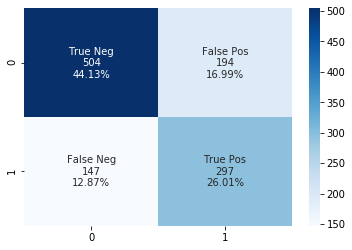

In [115]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Score model on submission data

In [128]:
subm_fname = '~/Data/Kaggle/real_or_not/sample_submission.csv'
subm = pd.read_csv(subm_fname)
subm.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [116]:
test_fname = '~/Data/Kaggle/real_or_not/test.csv'
test_df = pd.read_csv(test_fname)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [117]:
%%time
test_df['tokens'] = test_df['text'].apply(lambda x: cleaner(x))
test_df.head()

CPU times: user 4.42 s, sys: 559 ms, total: 4.98 s
Wall time: 4.99 s


,id,keyword,location,text,tokens
0,0,NaN,NaN,Just happened a terrible car crash,"[happen, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","[heard, earthquake, different, city, stay, safe]"
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, flee, street..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, light, spokane, wildfire]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kill, china, taiwan]"


In [118]:
test_df['clean_tweet'] = test_df['tokens'].apply(lambda x: detokenizer(x))

In [119]:
test_sentence_data = test_df['clean_tweet'].to_list()

In [120]:
test_X = vectorizer.transform(test_sentence_data)

In [123]:
test_X1 = standardizer.transform(test_X)

In [124]:
test_X1 = data_compressor.transform(test_X1)

In [125]:
test_X1.shape

(3263, 32)

In [126]:
y_pred = model.predict(test_X1)

In [129]:
subm['target'] = y_pred

In [130]:
subm.to_csv('tfidf_results.csv', index=False)